# Advanced Lane Finding Project

## Camera Calibration
In this section, compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

First we find the corners of the chessboard images. From result, we can see that there are 20 images but only 17 of them can find chessboard corners.

In [155]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline


# prepare object points
nx = 9
ny = 6

# Make a list of calibration images
fname_list = glob.glob("./camera_cal/*.jpg")
count = 0

objpoints = []
imgpoints = []
imgs = []
chess_imgs = []

# Chessboard coordinates
objp = np.zeros((ny*nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

for i in range(len(fname_list)):
    fname = fname_list[i]
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, append the result
    if ret == True:
        count += 1
        objpoints.append(objp)
        imgpoints.append(corners)

        chess_img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        chess_imgs.append(chess_img)
        imgs.append(img)

print("There are {} files in the camera_cal dir but only {} of them can find the chessboard corners."
      .format(len(fname_list), count))

There are 20 files in the camera_cal dir but only 17 of them can find the chessboard corners.


Sample of the corners found in an image.


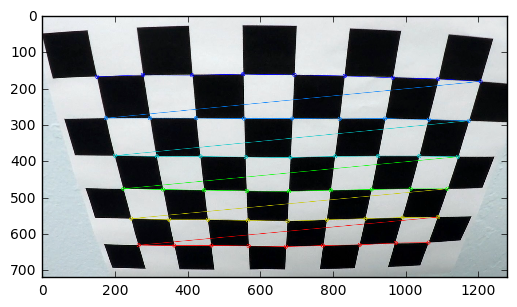

In [156]:
print("Sample of the corners found in an image.")
fig = plt.figure(1)
plt.imshow(chess_imgs[3])

Compute the camera calibration matrix and distortion coefficients

In [157]:
# Calculate camera calibration and distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

#* Undistort given image
def undistort(temp_img, temp_mtx, temp_dist):
    undist = cv2.undistort(temp_img, temp_mtx, temp_dist, None, temp_mtx)
    return undist

Sample of image before and after undistortion.


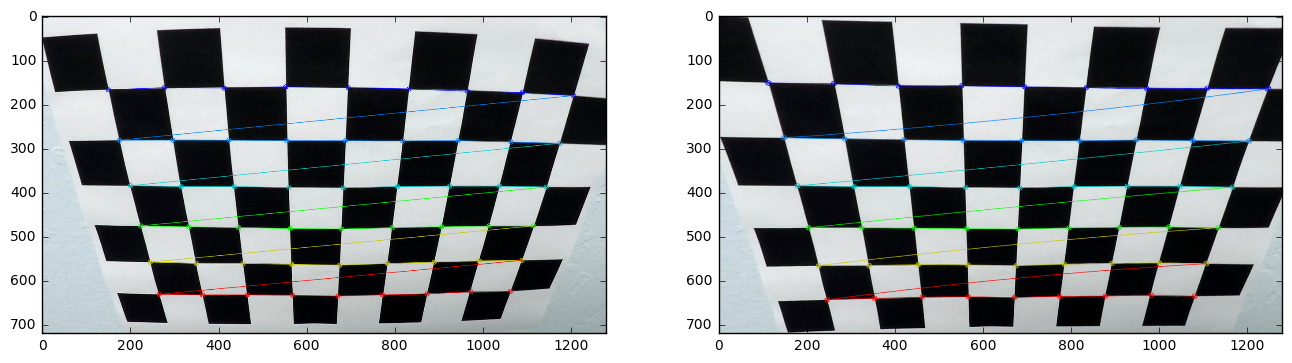

In [158]:
print("Sample of image before and after undistortion.")
fig = plt.figure(2,figsize=(16,8))

plt.subplot(121)
plt.imshow(imgs[3])

plt.subplot(122)
plt.imshow(undistort(imgs[3], mtx, dist))

plt.show()

## Pipeline(Single image)

### Distortion correction

Sample of image before and after undistortion.


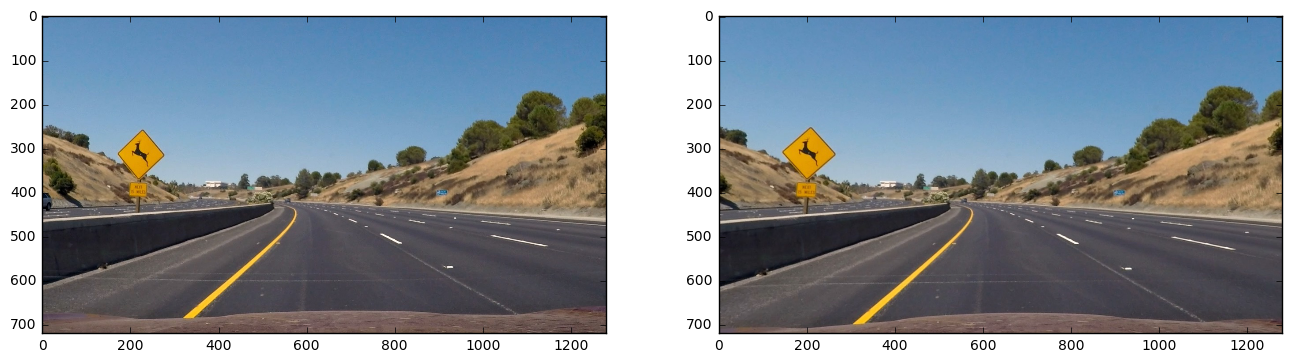

In [159]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Reverse the bgr image to rgb image
def reverseBGR(bgr_img):
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

test_fname_list = glob.glob("./test_images/*.jpg")
test_img = cv2.imread(test_fname_list[5])

print("Sample of image before and after undistortion.")
fig = plt.figure(3,figsize=(16,8))

plt.subplot(121)
plt.imshow(reverseBGR(test_img))

plt.subplot(122)
plt.imshow(reverseBGR(undistort(test_img, mtx, dist)))

plt.show()

### Create a thresholded binary image

#### Gradient related functions

In [160]:
# All gradient related functions
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image

    return sbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    # abs_sobelx = np.absolute(sobelx)
    # abs_sobely = np.absolute(sobely)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    abs_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sbinary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_gradient = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dir_gradient)
    binary_output[(dir_gradient >= thresh[0]) & (dir_gradient <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

Sample of images after applying thresholding functions.


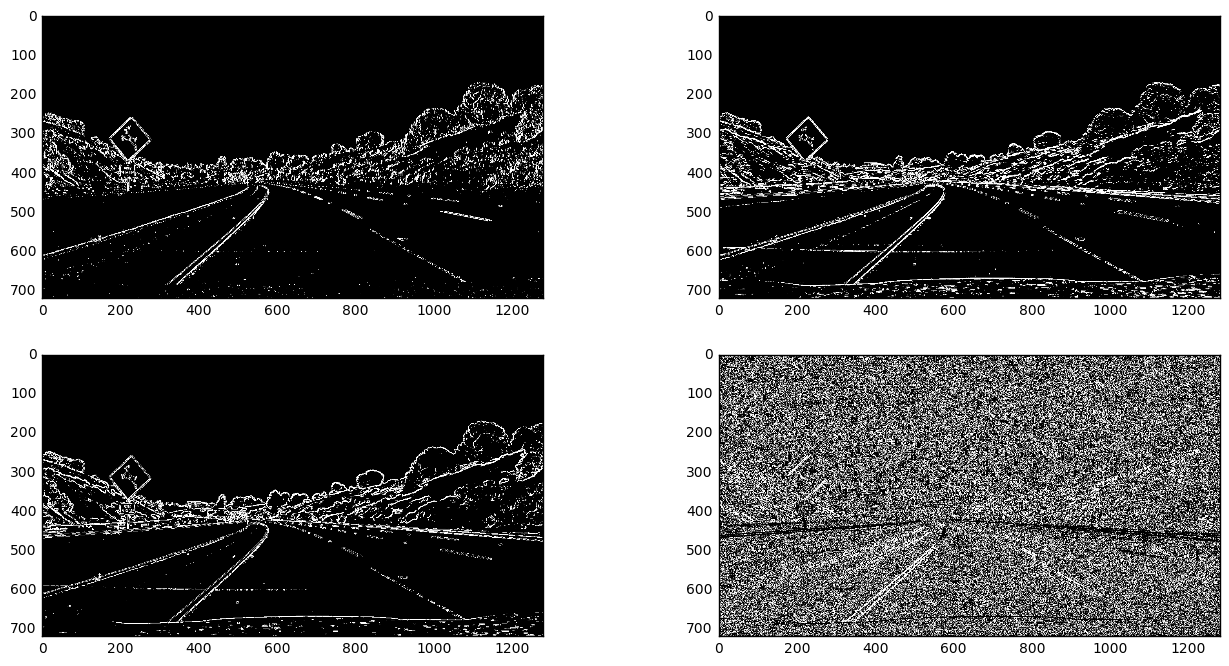

In [161]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(test_img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(test_img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(test_img, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(test_img, sobel_kernel=ksize, thresh=(0.7, 1.3))

print("Sample of images after applying thresholding functions.")
fig = plt.figure(4,figsize=(16,8))

plt.subplot(221)
plt.imshow(gradx, cmap='gray')

plt.subplot(222)
plt.imshow(grady, cmap='gray')

plt.subplot(223)
plt.imshow(mag_binary, cmap='gray')

plt.subplot(224)
plt.imshow(dir_binary, cmap='gray')

plt.show()


Combine the gradient thresholding results

Combined thresholding result


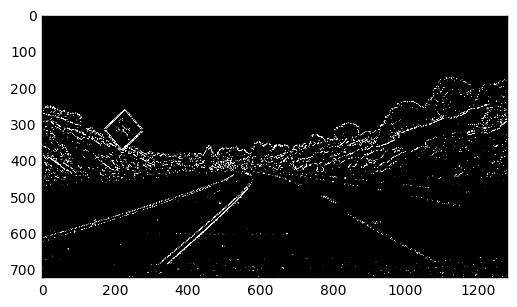

In [162]:
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

print("Combined thresholding result")
plt.imshow(combined, cmap='gray')

#### Color space related functions

In [163]:
hls = cv2.cvtColor(test_img, cv2.COLOR_RGB2HLS).astype(np.float)
s_channel = hls[:,:,2]
s_thresh = (170,255)

# Threshold color channel
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
# Stack each channel
# Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
# be beneficial to replace this channel with something else.
color_binary = np.dstack(( np.zeros_like(combined), combined, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(combined)
combined_binary[(s_binary == 1) | (combined == 1)] = 1

Combined thresholding & color space result


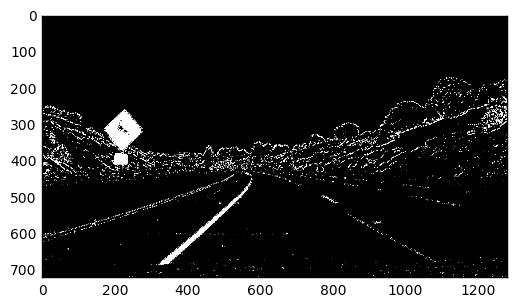

In [164]:
print("Combined thresholding & color space result")
plt.imshow(combined_binary, cmap='gray')

#### Function below is the part of the pipeline.

In [165]:
#* Return result of combined binary of gradients and color threshold
def combine_binarys(input_img, ksize):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(input_img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(input_img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(input_img, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(input_img, sobel_kernel=ksize, thresh=(0.7, 1.3))
    combined_gradients = np.zeros_like(dir_binary)
    combined_gradients[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # Apply color threshold function
    hls = cv2.cvtColor(input_img, cv2.COLOR_BGR2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    s_thresh = (100,255)

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(combined)
    combined_binary[(s_binary == 1) | (combined_gradients == 1)] = 1
    
    return combined_binary
    

### Perspective transform

In [186]:
img_size = gray.shape[::-1]
src = np.float32(
     [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
     [((img_size[0] / 6) - 10), img_size[1]],
     [(img_size[0] * 5 / 6) + 60, img_size[1]],
     [(img_size[0] / 2 + 60), img_size[1] / 2 + 100]])
dst = np.float32(
     [[(img_size[0] / 4), 0],
     [(img_size[0] / 4), img_size[1]],
     [(img_size[0] * 3 / 4), img_size[1]],
     [(img_size[0] * 3 / 4), 0]])

src_points_x = np.append(src[:,0], src[:,0][0])
src_points_y = np.append(src[:,1], src[:,1][0])
dst_points_x = np.append(dst[:,0], dst[:,0][0])
dst_points_y = np.append(dst[:,1], dst[:,1][0])

In [188]:
print(src_points_x)
print(src_points_y)
print(dst_points_x)
print(dst_points_y)

[  580.           203.33332825  1126.66662598   700.           580.        ]
[ 460.  720.  720.  460.  460.]
[ 320.  320.  960.  960.  320.]
[   0.  720.  720.    0.    0.]


In [167]:
#* Perspective transform
def corners_unwarp(img, nx, ny, mtx, dist, src, dst, is_grayscaled=False):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    # 2) Convert to grayscale
    # 3) Find the chessboard corners
    # 4) If corners found: 
            # a) draw corners
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            # e) use cv2.warpPerspective() to warp your image to a top-down view
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    if is_grayscaled == False:
        gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    img_size = gray.shape[::-1]

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M

Sample of a straight line before and after perspective transform.


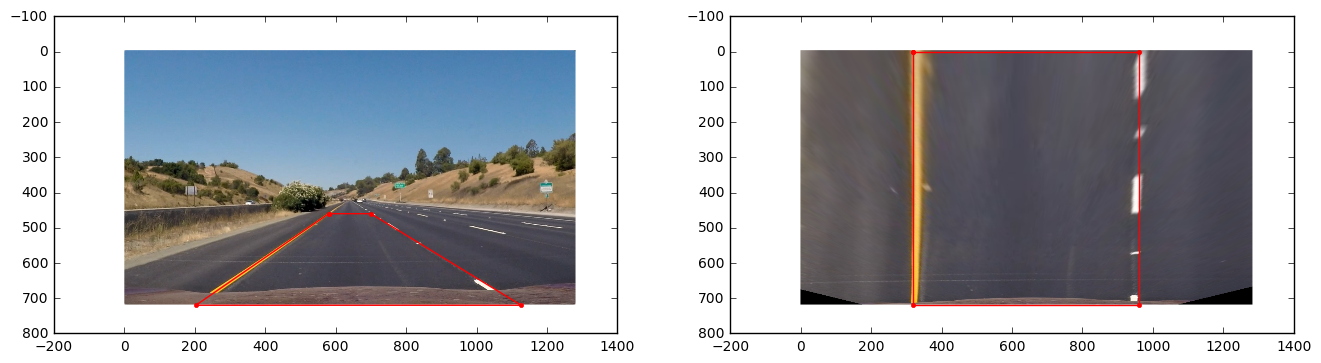

In [168]:
print("Sample of a straight line before and after perspective transform.")
srt_line = cv2.imread("./test_images/straight_lines1.jpg")
top_down, perspective_M = corners_unwarp(srt_line, nx, ny, mtx, dist, src, dst)

fig = plt.figure(3,figsize=(16,8))

plt.subplot(121)
plt.imshow(reverseBGR(srt_line))
plt.plot(src_points_x, src_points_y, marker='.', color='r')

plt.subplot(122)
plt.imshow(reverseBGR(top_down))
plt.plot(dst_points_x, dst_points_y, marker='.', color='r')

plt.show()

### Image preProcess pipeline

c_binary type: <class 'numpy.ndarray'>


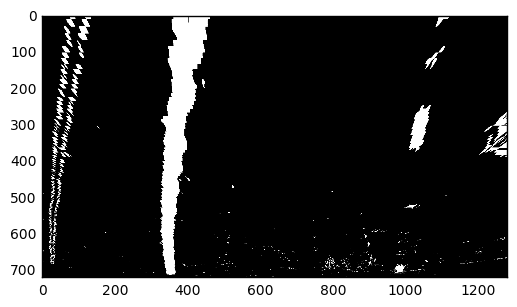

In [169]:
# Input bgr image --> output binary wraped image
def img_pre_process(temp_img, ksize):
    
    # Undistort the input image.
    undistort_img = undistort(temp_img, mtx, dist)
    
    # Get binary image using color & gradient threshold.
    c_binary = combine_binarys(undistort_img, ksize) 
    c_binary = c_binary.astype(np.uint8)
    print("c_binary type: " + str(type(c_binary)))
    
    # Perspective transform.
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(c_binary, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

pip_img = cv2.imread("./test_images/test1.jpg")
binary_warped = img_pre_process(pip_img, 3)

plt.imshow(binary_warped, cmap='gray')

### Find the lanes

In [189]:
# Input binary wraped image --> output polynomial fit params of left and right line, 
def fit_polys_sliding_window(in_binary_warped, ym_per_pix = 30/720, xm_per_pix = 3.7/700):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(in_binary_warped[in_binary_warped.shape[0]/2:,:], axis=0)
    # x_axis = range(len(histogram))
    # plt.plot(x_axis, histogram)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((in_binary_warped, in_binary_warped, in_binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(in_binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = in_binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # # Step through the windows one by one
    for window in range(nwindows):
    #     Identify window boundaries in x and y (and right and left)
        win_y_low = in_binary_warped.shape[0] - (window+1)*window_height
        win_y_high = in_binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    y_eval = in_binary_warped.shape[0]
    # Now our radius of curvature is in meters
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Calculate the offset of car with respect to lane center in meters
    left_bottom = np.mean(nonzerox[left_lane_inds][nonzeroy[left_lane_inds] > 0.95 * nonzeroy[left_lane_inds].max()])
    right_bottom = np.mean(nonzerox[right_lane_inds][nonzeroy[right_lane_inds] > 0.95 * nonzeroy[right_lane_inds].max()])
    lane_width = right_bottom - left_bottom
    mid_pos = in_binary_warped.shape[1] / 2
    offset_pixels = abs((left_bottom + lane_width / 2) - mid_pos)
    offset_meters = xm_per_pix * offset_pixels
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, left_curverad, right_curverad, offset_meters

#### Visualization

(720, 0)

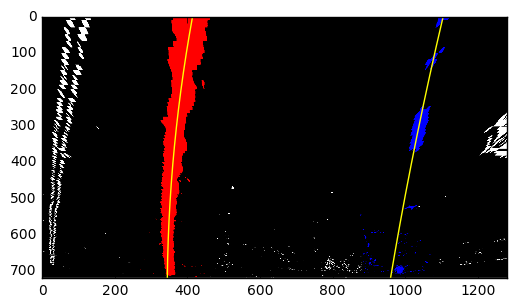

In [180]:
# Generate x and y values for plotting
left_fit, right_fit, left_lane_inds, right_lane_inds, out_img_visualize, left_curverad, right_curverad, offset_meters = fit_polys_sliding_window(binary_warped)
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

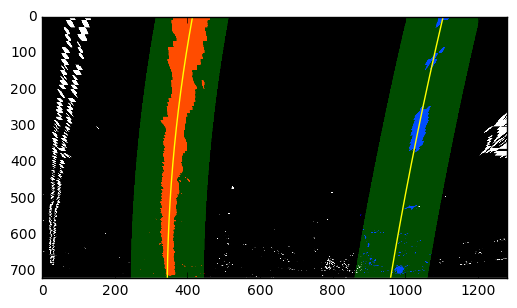

In [181]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
margin = 100

left_fit, right_fit, left_lane_inds, right_lane_inds, out_img_visualize, left_curverad, right_curverad, offset_meters  = fit_polys_sliding_window(binary_warped)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

#### Calculate the radius of curvature of the lane and the position of the vehicle with respect to center

In [173]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
y_eval = img_size[1]

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

In [174]:
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

1379.46664429 m 3481.14458739 m


In [175]:
# Calculate the deviation of car from center of lane in meters.
def cal_deviation(left_lane_inds, right_lane_inds, img_w_h, binary_w):
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    left_bottom = np.mean(nonzerox[left_lane_inds][nonzeroy[left_lane_inds] > 0.95 * nonzeroy[left_lane_inds].max()])
    right_bottom = np.mean(nonzerox[right_lane_inds][nonzeroy[right_lane_inds] > 0.95 * nonzeroy[right_lane_inds].max()])
    lane_width = right_bottom - left_bottom
    mid_pos = img_w_h[0] / 2
    offset_pixels = abs((left_bottom + lane_width / 2) - mid_pos)
    offset_meters = xm_per_pix * offset_pixels
    
    return offset_meters

### Main pipeline

True

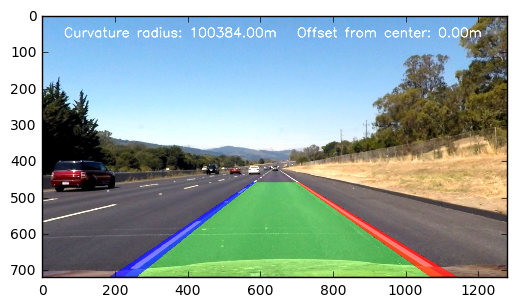

In [192]:
def draw_road_lane(undistort_img, src, dst, in_left_fit, in_right_fit, mean_curve_m, offset_meter):
    height, width, _ = undistort_img.shape
    Minv = cv2.getPerspectiveTransform(dst, src)
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, height - 1, height)
    left_fitx = in_left_fit[0] * ploty ** 2 + in_left_fit[1] * ploty + in_left_fit[2]
    right_fitx = in_right_fit[0] * ploty ** 2 + in_right_fit[1] * ploty + in_right_fit[2]

    # draw road as green polygon on original frame
    road_warp = np.zeros_like(undistort_img, dtype=np.uint8)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(road_warp, np.int_([pts]), (0, 255, 0))
    road_dewarped = cv2.warpPerspective(road_warp, Minv, (width, height))  # Warp back to original image space

    blend_onto_road = cv2.addWeighted(undistort_img, 1., road_dewarped, 0.3, 0)

    # now separately draw solid lines to highlight them
    line_warp = np.zeros_like(undistort_img)
    line_warp = draw(line_warp, in_left_fit, color=(255, 0, 0), average=False)
    line_warp = draw(line_warp, in_right_fit, color=(0, 0, 255), average=False)
    line_dewarped = cv2.warpPerspective(line_warp, Minv, (width, height))

    lines_mask = blend_onto_road.copy()
    idx = np.any([line_dewarped != 0][0], axis=2)
    lines_mask[idx] = line_dewarped[idx]

    blend_onto_road = cv2.addWeighted(src1=lines_mask, alpha=0.8, src2=blend_onto_road, beta=0.5, gamma=0.)
    
    # add text (curvature and offset info) on the upper right of the blend
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(blend_onto_road, 'Curvature radius: {:.02f}m'.format(mean_curve_m), (60, 60), font, 1.2, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(blend_onto_road, 'Offset from center: {:.02f}m'.format(offset_meter), (700, 60), font, 1.2, (255, 255, 255), 2, cv2.LINE_AA)

    return blend_onto_road


def draw(mask, coeffs, color=(255, 0, 0), line_width=50, average=False):
    """
    Draw the line on a color mask image.
    """
    h, w, c = mask.shape

    plot_y = np.linspace(0, h - 1, h)

    line_center = coeffs[0] * plot_y ** 2 + coeffs[1] * plot_y + coeffs[2]
    line_left_side = line_center - line_width // 2
    line_right_side = line_center + line_width // 2

    # Some magic here to recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array(list(zip(line_left_side, plot_y)))
    pts_right = np.array(np.flipud(list(zip(line_right_side, plot_y))))
    pts = np.vstack([pts_left, pts_right])

    # Draw the lane onto the warped blank image
    return cv2.fillPoly(mask, [np.int32(pts)], color)
    

def pipeline(original_img):
    # Get undistort image.
    undistort_img = undistort(original_img, mtx, dist)
    # Get binary image using color & gradient threshold.
    c_binary = combine_binarys(undistort_img, ksize).astype(np.uint8)
    # Perspective transform.
    M = cv2.getPerspectiveTransform(src, dst)
    binarized = cv2.warpPerspective(c_binary, M, img_size, flags=cv2.INTER_LINEAR)
    # Fit polys using sliding window.
    l_fit, r_fit, l_lane_inds, r_lane_inds, binarized_img, l_curve_m, r_curve_m, offset_meter = fit_polys_sliding_window(binarized)
    # Calculate offset of car respective to lane center in meters.
#     offset_meter = cal_deviation(l_lane_inds, r_lane_inds, img_size, binarized)
    
    # Draw mask to undistort image.
    road_with_mask = draw_road_lane(undistort_img, src, dst, l_fit, r_fit, (l_curve_m + r_curve_m)//2, offset_meter)
    
    return road_with_mask
    
road_with_mask = pipeline(cv2.imread("./test_images/straight_lines2.jpg"))
plt.imshow(cv2.cvtColor(road_with_mask, code=cv2.COLOR_BGR2RGB), cmap='gray')
cv2.imwrite('output_images/2.jpg', road_with_mask)

## Main Function

In [194]:
# Process test images and output to output_images folder.
fname_list = glob.glob("./test_images/*.jpg")
count = 0

for fname in fname_list:
    fn = fname.split('/')[-1]
    print("fanme:{}".format(fn))
    original_img = cv2.imread(fname)
    processed = pipeline(original_img)
    cv2.imwrite('output_images/{}'.format(fn), processed)
    count += 1
    
print("Process done! {} image processed through pipeline.".format(count))

fanme:test6.jpg
fanme:test5.jpg
fanme:test4.jpg
fanme:test1.jpg
fanme:test3.jpg
fanme:test2.jpg
fanme:straight_lines2.jpg
fanme:straight_lines1.jpg
Process done! 8 image processed through pipeline.


In [193]:
from moviepy.editor import VideoFileClip

selector = 'challenge'
clip = VideoFileClip('{}_video.mp4'.format(selector)).fl_image(pipeline)
clip.write_videofile('out_{}_video.mp4'.format(selector), audio=False)

[MoviePy] >>>> Building video out_challenge_video.mp4
[MoviePy] Writing video out_challenge_video.mp4


100%|██████████| 485/485 [02:15<00:00,  3.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_challenge_video.mp4 

